In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

import torchvision

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

Image Data from [here](https://www.kaggle.com/andrewmvd/animal-faces)
- Animal Faces

## Images

In [2]:
# What's in this dataset?
import os
os.listdir('course_data/afhq')

['train', 'val']

In [3]:
# three labels
os.listdir('course_data/afhq/train')

['cat', 'dog', 'wild']

In [4]:
# within each folder are the images
os.listdir('course_data/afhq/train/cat')[:5]

['pixabay_cat_000455.jpg',
 'pixabay_cat_001993.jpg',
 'pixabay_cat_004633.jpg',
 'pixabay_cat_002242.jpg',
 'pixabay_cat_002524.jpg']

In [5]:
# create a dataframe for our data
data_path = 'course_data/afhq'

rows = []
for dataset in os.listdir(data_path):
    for label in os.listdir(data_path + f'/{dataset}'):
        for image in os.listdir(data_path + f'/{dataset}' + f'/{label}'):
            row = dict()
            row['image_file'] = image
            row['label'] = label
            row['dataset'] = dataset
        
            # a bit redudant, could build from other data in __getitem__ if wanted
            row['image_path'] = data_path + f'/{dataset}' + f'/{label}'
            rows.append(row)
        
df = pd.DataFrame(rows)
print(len(df))
df.head()

16130


,image_file,label,dataset,image_path
0,pixabay_cat_000455.jpg,cat,train,course_data/afhq/train/cat
1,pixabay_cat_001993.jpg,cat,train,course_data/afhq/train/cat
2,pixabay_cat_004633.jpg,cat,train,course_data/afhq/train/cat
3,pixabay_cat_002242.jpg,cat,train,course_data/afhq/train/cat
4,pixabay_cat_002524.jpg,cat,train,course_data/afhq/train/cat


In [43]:
# training and validation data
df_train = df[df['dataset'] == 'train'].reset_index(drop=True)
df_val = df[df['dataset'] == 'val'].reset_index(drop=True)
len(df_train), len(df_val)

(14630, 1500)

Before creating a Dataset class, let's think about what we want as our input to the network

In [7]:
import cv2

# pull up an image
row = df.iloc[0]
image_path = row['image_path']
fname = row['image_file']
path = image_path+'/'+fname
img = cv2.imread(path)

# what is an image?
img

array([[[ 64, 121, 130],
        [ 58, 116, 122],
        [ 57, 112, 117],
        ...,
        [133, 191, 203],
        [133, 191, 203],
        [132, 190, 202]],

       [[ 61, 118, 127],
        [ 58, 113, 120],
        [ 54, 109, 112],
        ...,
        [133, 191, 203],
        [133, 191, 203],
        [132, 190, 202]],

       [[ 60, 115, 122],
        [ 54, 110, 115],
        [ 50, 106, 107],
        ...,
        [131, 191, 203],
        [131, 191, 203],
        [130, 190, 202]],

       ...,

       [[217, 210, 215],
        [217, 210, 215],
        [218, 211, 216],
        ...,
        [245, 233, 229],
        [251, 236, 233],
        [255, 240, 237]],

       [[216, 209, 214],
        [216, 209, 214],
        [217, 210, 215],
        ...,
        [248, 236, 232],
        [253, 241, 237],
        [255, 244, 240]],

       [[215, 208, 213],
        [216, 209, 214],
        [217, 210, 215],
        ...,
        [251, 240, 236],
        [255, 247, 243],
        [255, 250, 246]]

In [8]:
# 512x512 image with 3 channels
print(img.shape)

# pixel intensity goes from 0 to 255
print(np.max(img), np.min(img))

(512, 512, 3)
255 0


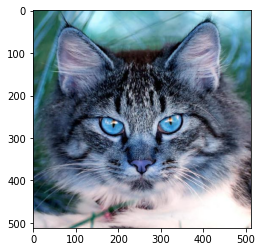

In [9]:
# look at the image
plt.imshow(img)

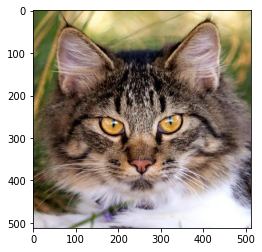

In [10]:
# why is it weird? cv2 opens in BGR instead of RGB
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Convolutional Layers
- [Documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) for ```Conv2d``` is a must-read

In [11]:
# number of channels of the input
in_channels = 3
# number of filters (hence number of output channels)
out_channels = 32
# filter size
kernel_size = 3 # equivalent to (3,3)

# define the layer
conv = nn.Conv2d(in_channels, out_channels, kernel_size)

# why error? (two reasons!)
conv(torch.tensor(img))

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [32, 3, 3, 3], but got 3-dimensional input of size [512, 512, 3] instead

In [16]:
# let's try again
img2 = img[np.newaxis, :, :, :]
img2 = np.transpose(img2, (0, 3, 1, 2))
print(img2.shape)
img2 = torch.tensor(img2).float()

output = conv(img2)

# why this shape?
output.shape

ValueError: axes don't match array

Think: How can we change this so that the output has the same 2D shape?

## Dataset and Model

In [11]:
# Let's create a Dataset for our animal faces! 
class AnimalFacesDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
        # label dictionary
        self.label_dict = {'cat':0, 'dog':1, 'wild':2}
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # get ingredients for retrieving image
        image_path = row['image_path']
        fname = row['image_file']
        path = image_path+'/'+fname
        
        # read the img
        img = cv2.imread(path)
        
        # convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # move color channels to correct spot
        img = np.transpose(img, (2, 0, 1))
        
        # convert to [0,1] scale
        img = torch.tensor(img / 255.).float()
        
        label = torch.tensor(self.label_dict[row['label']])
        
        return img, label

In [12]:
ds_train = AnimalFacesDataset(df_train)
dl_train = DataLoader(ds_train, batch_size = 8, shuffle=True)

In [13]:
# make sure our recipe works!
# notice the time...
for img, label in tqdm(dl_train):
    None

  0%|          | 0/1829 [00:00<?, ?it/s]

KeyboardInterrupt: 

Have to sketch out dimensions while constructing!

Input: (3, 512, 512)

Conv1 -> (32, 512, 512)

Pool -> (32, 256, 256)

Conv2 -> (64, 256, 256)

Pool -> (64, 128, 128)

Conv3 -> (128, 128, 128)

Pool -> (128, 64, 64)

Conv4 -> (1, 64, 64)

In [24]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # same padding!
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        # doing this to shrink size enough!
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=3, padding=1)
        
        self.linear1 = nn.Linear(4096, 100)
        
        # read documentation for CrossEntropyLoss!
        self.linear2 = nn.Linear(100, 3)
        
        # pooling
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # activation
        self.relu = nn.ReLU()
        
        # for unrolling into FC layer
        self.unroll = nn.Flatten()
        
    def forward(self, x):
        # helpful to do this along the way sometimes!
        #print(x.shape)
        
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv4(x)
        x = self.relu(x)
        
        # unroll x for FC layer
        x = self.linear1(self.unroll(x))
        x = self.relu(x)
        x = self.linear2(x)
        
        return x
    
model = CNN()

In [32]:
x, y = next(iter(dl_train))
softmax = nn.LogSoftmax(dim=1)
softmax(model(x))

tensor([[-1.0960, -1.1529, -1.0496],
        [-1.0960, -1.1529, -1.0496],
        [-1.0960, -1.1529, -1.0496],
        [-1.0960, -1.1529, -1.0496],
        [-1.0960, -1.1529, -1.0496],
        [-1.0960, -1.1529, -1.0496],
        [-1.0960, -1.1529, -1.0496],
        [-1.0960, -1.1529, -1.0496]], grad_fn=<LogSoftmaxBackward0>)

In [35]:
lossFun = nn.CrossEntropyLoss()

lossFun(model(x),y)

tensor(1.1187, grad_fn=<NllLossBackward0>)

In [ ]:
from torchsummary import summary
summary(model, input_size = (3, 512, 512), device='cpu')

In [36]:
# train the model
def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in tqdm(dataloader):
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

def one_pass_acc(model, dataloader, num_points):
    model.eval()
    total_incorrect = 0
    
    softmax = nn.LogSoftmax(dim=1)
    
    for x, y in dataloader:
        y_pred = softmax(model(x))
        y_pred = torch.argmax(y_pred, dim=1)
        
        total_incorrect += torch.count_nonzero(y - y_pred).item()
        
    percent_wrong = total_incorrect / num_points
    return 1 - percent_wrong

In [57]:
model = CNN()
lossFun = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 1
train_losses = []
valid_losses = []

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch)
    
    train_loss = one_pass(model, dl_train, optimizer, lossFun)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(model, dl_val, optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(model, dl_train, len(ds_train))
    valid_acc = one_pass_acc(model, dl_val, len(ds_val))
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:  0


  0%|          | 0/1829 [00:00<?, ?it/s]

KeyboardInterrupt: 